# **Taxi Driver Predictions**

## **Import Packages and Data**

In [229]:
# Import packages
import numpy as np
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

In [230]:
# Read data
taxi = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/taxi.csv', parse_dates=[0], index_col=[0])

In [231]:
# Print info
print(taxi.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Index is datetime and only one column with number of taxi orders. There are no missing values.

In [232]:
# Display head
display(taxi.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [233]:
# Check dates are ordered
print('Dates are ordered in increasing time:')
print(f'{taxi.index.is_monotonic_increasing}')

Dates are ordered in increasing time:
True


### Initial data observations

The dataset contains taxi orders in 10-minute intervals. There is only one column with number of taxi orders and 26496 observations. There are no missing values. The data is ready for analysis.

## **Prepare Data**

### Check date order

In [234]:
# Check dates are increasing
print('Dates are ordered in increasing time:')
print(f'{taxi.index.is_monotonic_increasing}')

Dates are ordered in increasing time:
True


### Group time by hour

In [235]:
# Resample by hour
taxi = taxi.resample('1H').sum()

display(taxi.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Dataframe is summed by hour.

## **Exploratory Analysis**

### Individual distributions

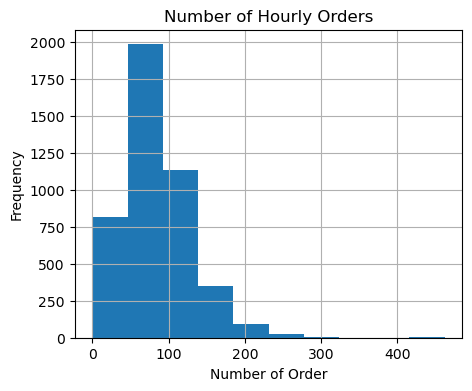

In [236]:
# Histogram of order number
plt.figure(figsize=(5, 4))

taxi['num_orders'].hist()

plt.title('Number of Hourly Orders')
plt.xlabel('Number of Order')
plt.ylabel('Frequency')

plt.show()

Number of orders by hour is left skewed, with most hours recieving 0 - 150 order and only a few hours recieving over 250 orders.

### Time series plot

In [237]:
# Calculate rolling mean and standard deviation by day
taxi['rolling_mean'] = taxi['num_orders'].rolling(24).mean()
taxi['std'] = taxi['num_orders'].shift().rolling(24).std()

display(taxi.sample(5))

,num_orders,rolling_mean,std
datetime,,,
2018-06-27 08:00:00,102,88.583333,27.979677
2018-06-07 04:00:00,83,76.041667,29.238617
2018-04-30 22:00:00,85,72.708333,34.726572
2018-03-07 22:00:00,127,58.083333,29.462824
2018-04-07 16:00:00,100,70.083333,38.125650


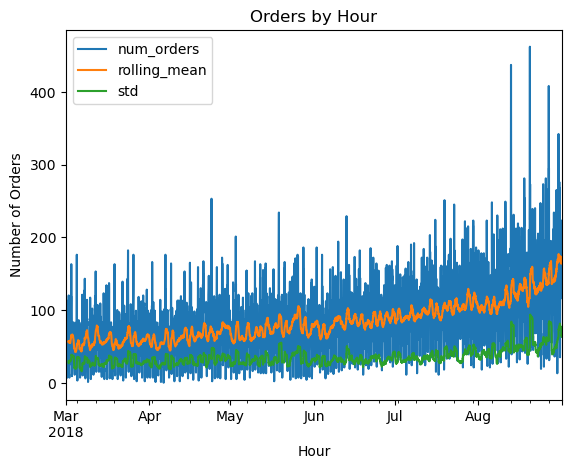

In [238]:
# Plot time series
taxi.plot()

plt.title('Orders by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.show()

The graph shows evidence of both seasonality and an upward trend in number of taxi orders per hour. Both the mean and standard deviation increase over time, so this is a non-stationary timeseries.

### Plot seasonality and trend

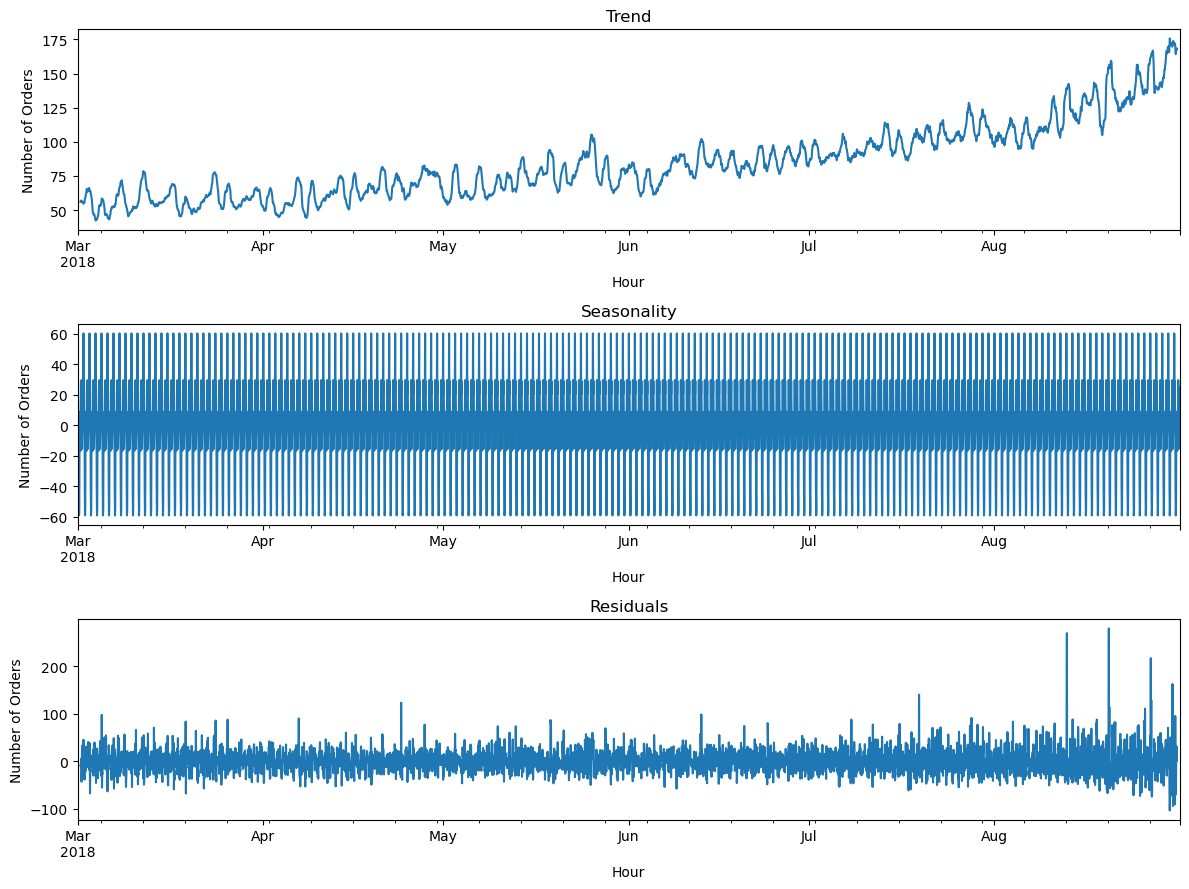

In [239]:
# Decompose data
decomposed = seasonal_decompose(taxi[['num_orders']])

# Plot trends
plt.figure(figsize=(12, 9))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.tight_layout()

plt.show()

There is a confirmed upward trend. Seasonality occurs in very short timeframes - possibly within the day.

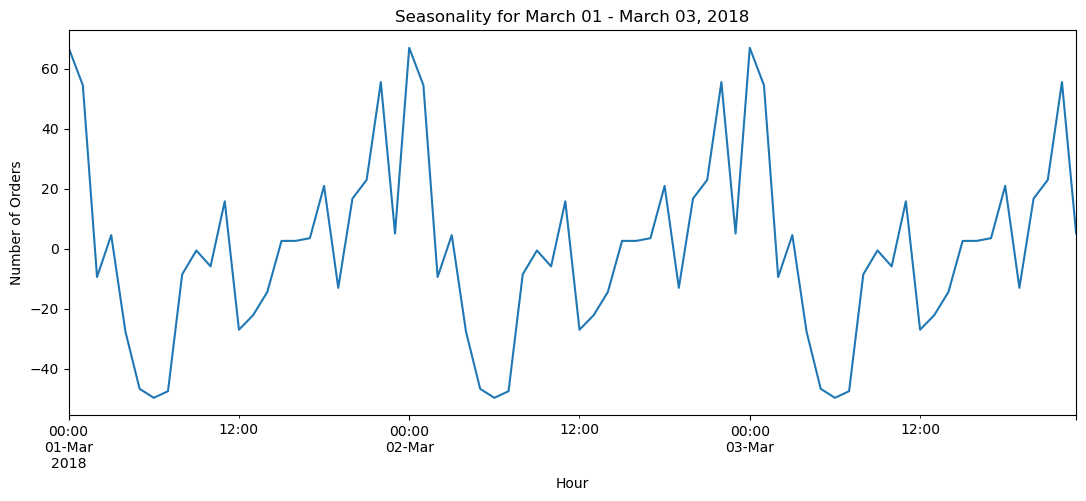

In [240]:
# Zoom in on 3 day seasonality
decomposed_3day = seasonal_decompose(taxi.loc['2018-03-01':'2018-03-03', 'num_orders'])

plt.figure(figsize=(13, 5))

decomposed_3day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality for March 01 - March 03, 2018')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.show()

Seasonality occurs within the day. Orders start low in the early morning and generally climb through the night.

### Exploratory analysis conclusions

Number of hourly orders range from 0 - 450, with most hours receiving 0 - 150 orders. The time series is non-stationary with an increasing mean and standard deviation over time. There is an upward trend and seasonality within the day.

## **Time Series Forecasting**

### Make features and target

In [241]:
# Add date features
taxi['year'] = taxi.index.year
taxi['month'] = taxi.index.month
taxi['day'] = taxi.index.day
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

taxi = taxi.dropna()

features = taxi.drop(['num_orders', 'std'], axis=1)
target = taxi['num_orders']

print('Features:')
display(features.head())
print('Target:')
display(target.head().to_frame())

Features:


,rolling_mean,year,month,day,dayofweek,hour
datetime,,,,,,
2018-03-02 00:00:00,55.416667,2018,3,2,4,0
2018-03-02 01:00:00,56.875000,2018,3,2,4,1
2018-03-02 02:00:00,57.041667,2018,3,2,4,2
2018-03-02 03:00:00,56.958333,2018,3,2,4,3
2018-03-02 04:00:00,56.000000,2018,3,2,4,4


Target:


,num_orders
datetime,
2018-03-02 00:00:00,90
2018-03-02 01:00:00,120
2018-03-02 02:00:00,75
2018-03-02 03:00:00,64
2018-03-02 04:00:00,20


### Split train and test

In [242]:
# Create training and test sets
feat_train, feat_test, targ_train, targ_test = train_test_split(
    features, target, test_size=0.1, shuffle=False)

print(f'Features Train shape: {feat_train.shape}')
print(f'Features Test shape: {feat_test.shape}')
print(f'Target Train shape: {targ_train.shape}')
print(f'Target Test shape: {targ_test.shape}')

Features Train shape: (3952, 6)
Features Test shape: (440, 6)
Target Train shape: (3952,)
Target Test shape: (440,)


Text(0, 0.5, 'Number of Orders')

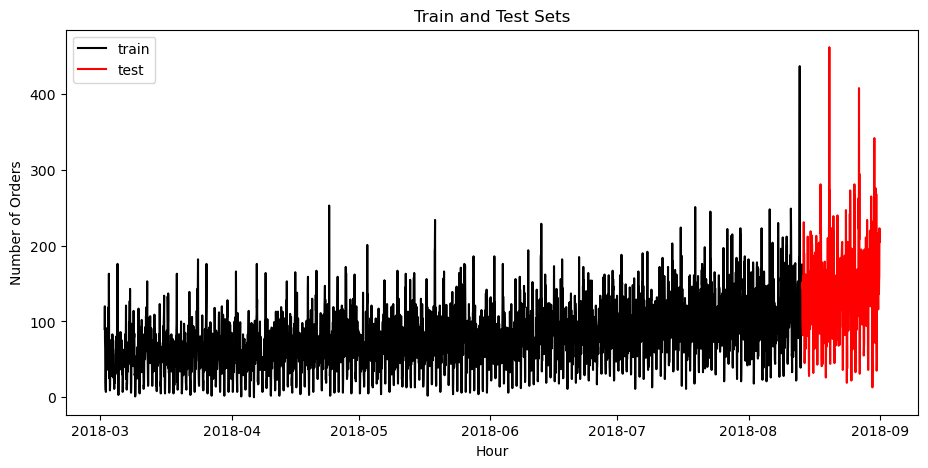

In [243]:
# Plot train and test
plt.figure(figsize=(11, 5))

plt.plot(targ_train, color='black', label='train')
plt.plot(targ_test, color='red', label='test')

plt.legend()

plt.title('Train and Test Sets')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

### Baseline model

In [244]:
# Use previous value to predict next value
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

base_rmse = mean_squared_error(test, pred_previous, squared=False)

print(f'Base RMSE: {base_rmse:.2f}')

Base RMSE: 58.86


### Linear Regression

In [253]:
# Tune regression to minimize rmse
best_lags = 0
best_rmse = base_rmse
best_predictions = []

feat_names = ['rolling_mean']

for lag in range(1, 100, 10):
    regression = ForecasterAutoreg(regressor=LinearRegression(), lags=lag)
    regression.fit(y=targ_train, exog=feat_train[feat_names])
    
    predictions = regression.predict(steps=len(targ_test), exog=feat_test[feat_names])
    rmse = mean_squared_error(targ_test, predictions, squared=False)
    
    if rmse < best_rmse:
        best_lags = lag
        best_rmse = rmse
        best_predictions = predictions

print(f'Best number of lags: {best_lags}')
print(f'Best RMSE Test: {best_rmse:.2f}')

Best number of lags: 41
Best RMSE Test: 0.00


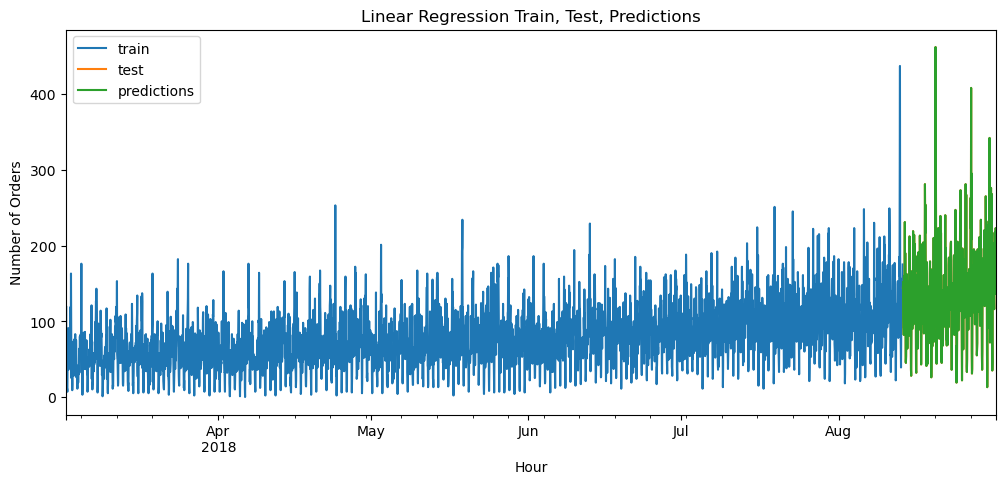

In [249]:
# Plot train, test, and predictions of best linear model
fig, ax = plt.subplots(figsize=(12, 5))

targ_train.plot(ax=ax, label='train')
targ_test.plot(ax=ax, label='test')
best_predictions.plot(ax=ax, label='predictions')

ax.legend()

plt.title('Linear Regression Train, Test, Predictions')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.show()

#### Linear regression conclusions

Using a rolling mean of size 24 and 41 lag features, linear regression trained on the training set was able to achieve and RMSE of 0.00 on the test set. This represents perfect predictions of the test values.

### Random Forest

In [247]:
lags = [np.arange(1, 20)]

grid = {
    'fit_intercept':['False']
}

regression_gsf = grid_search_forecaster(
    forecaster=regression,
    y=train['num_orders'],
    param_grid=grid,
    lags_grid=lags,
    steps=12,
    initial_train_size=3000,
    fixed_train_size = False,
    metric='mean_squared_error',
    return_best=True
)

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

InvalidParameterError: The 'fit_intercept' parameter of LinearRegression must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got 'False' instead.